In [238]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [261]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import datetime
from scipy.io import loadmat
from collections import defaultdict
from IPython.display import clear_output
import math
import random
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [240]:
year = 2003
month = 2
day = 10
hour = 0
minute = 0
second = 0

startDateMatlab = [year, month, day, hour, minute, second]
endDateMatlab = [year, month, day+2, hour+23, minute+59, second+59]

startDate = datetime.datetime(year, month, day, hour, minute, second)
endDate = datetime.datetime(year, month, day+2, hour+23, minute+59, second+59)


stationsWithNoData = []
stationsNonexistentInFolder = []
stationsOut = dict()
dotsX=[]
dotsY=[]
dotsHeights=[]
stationIndicatorVariation = defaultdict(list)

mat = loadmat("../../../../opt/dir.indices/station.mat")

allMatData = mat.get("station", "none")[0]
allStationCodes=[]

for x in allMatData:
    allStationCodes.append(x[1][0])
    

In [241]:
singleStation="clf"
stationsOut[singleStation] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(singleStation))

In [242]:
%%time
for st in allStationCodes: 
    try:
        stationsOut[st] = eng.indices_alpha(matlab.double(startDateMatlab), matlab.double(endDateMatlab),str(st))
    except:
        stationsNonexistentInFolder.append(st)

CPU times: user 645 ms, sys: 147 ms, total: 792 ms
Wall time: 4.47 s


In [243]:
def IndicatorCalculation(dataSt, timeshift, currentDate):
    
#     a1=np.float32(dataSt.get("a1")[timeshift])
#     x=np.float32(dataSt.get("x")[timeshift])
    x1=np.float32(dataSt.get("x1")[timeshift])
    x2=np.float32(dataSt.get("x2")[timeshift])
#     x3=np.float32(dataSt.get("x3")[timeshift])
#     x4=np.float32(dataSt.get("x4")[timeshift])
    y=np.float32(dataSt.get("y")[timeshift])
    y1=np.float32(dataSt.get("y1")[timeshift])
#     y2=np.float32(dataSt.get("y2")[timeshift])
#     y3=np.float32(dataSt.get("y3")[timeshift])
#     y4=np.float32(dataSt.get("y4")[timeshift])
    z1=np.float32(dataSt.get("z1")[timeshift])
    stLongeo=np.float32(dataSt.get("longeo"))
    stLatgeo=np.float32(dataSt.get("latgeo"))
    stAlt=np.float32(dataSt.get("alt"))
    
    currentDateMatlab = [currentDate.year, currentDate.month, currentDate.day, currentDate.hour, currentDate.minute, currentDate.second]
    
    b=eng.igrf(matlab.double([stLongeo]), matlab.double([stLatgeo]), matlab.double([stAlt]), matlab.double([currentDateMatlab]), nargout=4)
    
    ratio = (((math.sqrt(pow(x1, 2)+pow(y1, 2)+pow(z1, 2)))/b[3])-1)*100
#     indicator = gaussian(ratio, 1, 0)
    return np.round(x2,10)

In [244]:
%%time
stationIndicatorVariation.clear()
timeBetweenValues = 1
dataResolution = 0
dataBeforeNormalizaton = np.array([])
st = singleStation
delta = endDate-startDate
totalMinutes = (delta.total_seconds()+1)/60
for i in range(0, np.int16(totalMinutes+1), timeBetweenValues):
    try:
        update = datetime.timedelta(minutes=i)
        currentDate = startDate+update
        stationIndicatorVariation[st].append(float(IndicatorCalculation(stationsOut.get(st), i, currentDate)))
    except:
        None

CPU times: user 5.81 s, sys: 246 ms, total: 6.06 s
Wall time: 9.23 s


In [245]:
normalized01StationIndicatorVariation = defaultdict(list)

def NormalizeData01():
    max_values = np.array([])
    min_values = np.array([])
    
    for st in allStationCodes:
        if stationIndicatorVariation[st]:
            if not math.isnan(stationIndicatorVariation[st][0]):
                max_values = np.append(max_values, max(stationIndicatorVariation[st])) 
                min_values = np.append(min_values, min(stationIndicatorVariation[st]))
    
    totalMax = max(max_values)
    totalMin = min(min_values)
    
    for st in allStationCodes:
        for i in range(0, len(stationIndicatorVariation[st])):
            normalized01StationIndicatorVariation[st].append((stationIndicatorVariation[st][i] - totalMin) / (totalMax - totalMin))
            
NormalizeData01()

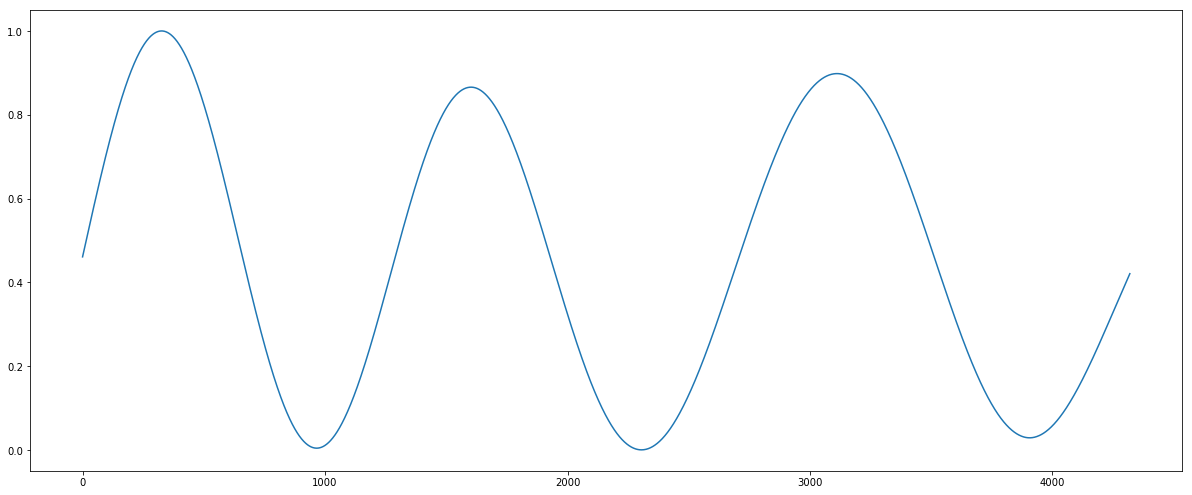

In [246]:
y = np.array(normalized01StationIndicatorVariation[singleStation])
x = np.arange(0, 4320, timeBetweenValues)
fig= plt.figure(figsize=(20,8))
axes= fig.add_axes([0.8,0.8,0.8,0.8])
axes.plot(x,y)
plt.show()

In [247]:
def RemoveInfNan(latValues, indicatorValues):
    indexDeleteY = np.array([])
    for i in range(0, indicatorValues.shape[0]):
        if math.isinf(indicatorValues[i]) or math.isnan(indicatorValues[i]):
            indexDeleteY = np.append(indexDeleteY, i)
    newY = np.delete(indicatorValues, indexDeleteY)
    newX = np.delete(latValues, indexDeleteY)
    newY=newY.reshape(newY.shape[0],1)
    newX=newX.reshape(newY.shape[0],1)
    
    return newX, newY

In [248]:
predictionGap = np.array([])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0, shuffle=True)



def RemoveDataRandomly(x,y):
    rand = np.array([])
    r=0
    for i in range(0,y.shape[0]/2):
        while r in rand:
            r = random.randint(0,y.shape[0])
        rand = np.append(rand, r)

    for i in range(0,rand.shape[0]):
        y_train[np.int16(rand[i])] = np.nan
        
        
def RemoveDataGap(start, end):
    global predictionGap
    
    for i in range(start, end, 1):
        for y in range(0, X_train.shape[0]):
            if i == X_train[y]:
                y_train[y] = np.nan
                predictionGap = np.append(predictionGap,X_train[y])
        
# RemoveDataRandomly()
dataGaps = np.array([[200,500], [1000,1400], [2000,2500], [3200,3600], [3900,4200]])
for i in range(dataGaps.shape[0]):
    RemoveDataGap(dataGaps[i][0],dataGaps[i][1])

In [249]:
X_train = X_train.reshape(X_train.shape[0], 1)
y_train = y_train.reshape(y_train.shape[0], 1) 
X_test = X_test.reshape(X_test.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

X_train, y_train = RemoveInfNan(X_train, y_train)

/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  
/home/cristille/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  import sys


In [259]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

params = {'polynomialfeatures__degree': np.arange(5,20,1), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]}
poly_grid = GridSearchCV(PolynomialRegression(), params, cv=10, scoring='r2', verbose=1) #Scoring with coefficient of determination r2
poly_grid.fit(X_train, y_train)
print("Best hyper parameters found at: {}".format(poly_grid.best_params_))
print("With {}% accuracy".format(poly_grid.best_score_))

Fitting 10 folds for each of 60 candidates, totalling 600 fits
Best hyper parameters found at: {'linearregression__normalize': True, 'polynomialfeatures__degree': 19, 'linearregression__fit_intercept': True}
With 0.999999941492% accuracy


[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:    4.9s finished


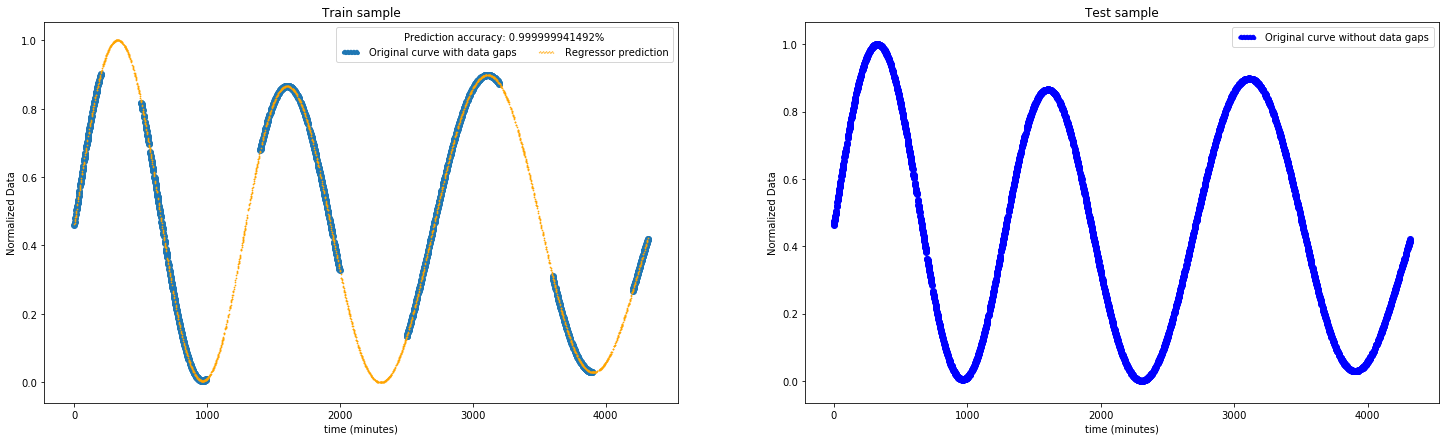

In [260]:
fig, (ax1, ax2) = plt.subplots(1, 2)
baseCurveGaps = ax1.scatter(X_train, y_train)
ax1.title.set_text('Train sample')
yLabels = poly_grid.predict(X_test)
predictedCurve = ax1.scatter(X_test, yLabels,s=0.5,c='orange')
ax2.title.set_text('Test sample')
baseCurve = ax2.scatter(X_test, y_test, c='blue')
fig.set_size_inches(25,7)
ax1.set_xlabel("time (minutes)")
ax1.set_ylabel("Normalized Data")
ax2.set_xlabel("time (minutes)")
ax2.set_ylabel("Normalized Data")

ax1.legend([baseCurveGaps, predictedCurve], ['Original curve with data gaps', 'Regressor prediction'],
              loc = 'upper right', ncol = 2, scatterpoints = 15,
              frameon = True, markerscale = 0.5,
              borderpad = 0.5, labelspacing = 0.5, title = 'Prediction accuracy: {}%'.format(poly_grid.best_score_))
ax2.legend([baseCurve], ['Original curve without data gaps'],
              loc = 'upper right', ncol = 2, scatterpoints = 15,
              frameon = True, markerscale = 0.5,
              borderpad = 0.5, labelspacing = 0.5)

fig.savefig("DataGaps_TrainAndTestSamples")